<a href="https://colab.research.google.com/github/farshidb94/BrainCircuitSimulation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### **One Brain Cell**

In [13]:
# Izhikevich model parameters:
a = 0.02     # Time scale of the recovery variable u (smaller = slower recovery)
b = 0.2      # Sensitivity of u to the subthreshold fluctuations of v
c = -50      # Membrane potential reset value after a spike (in mV)
d = 2        # Amount by which the recovery variable u is increased after a spike

v = -65      # Initial membrane potential (in mV)
u = b * v    # Initial recovery variable (proportional to v at start)


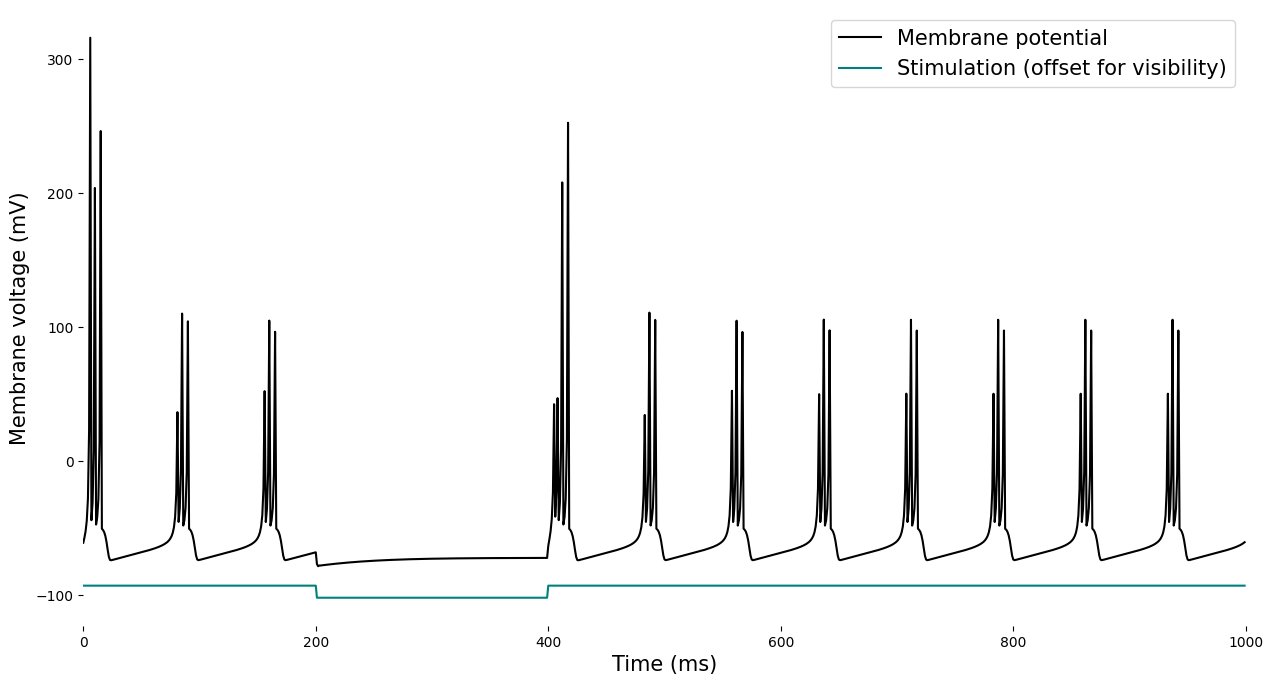

In [14]:
# Initialize simulation parameters
simulation_time = 1000  # Total simulation time in ms
memvolt = np.zeros(simulation_time)  # Stores membrane potential v for each ms
Iall = np.zeros(simulation_time)     # Stores input current I for each ms

# Run simulation over time
for t in range(simulation_time):

    # Define exogenous (external) input current
    # Negative current between 200 and 400 ms, otherwise positive
    I = -2 if (t > 200) & (t < 400) else 7
    # To use random input, uncomment the following line:
    # I = 6 * np.random.rand()

    # Spike condition: if neuron fires (v crosses threshold)
    if v >= 30:
        v = c   # Reset membrane potential to c
        u += d  # Increase recovery variable by d

    # Update equations for v (membrane potential) and u (recovery variable)
    v += 0.04 * v**2 + 5 * v + 140 - u + I
    u += a * (b * v - u)

    # Record values for plotting
    memvolt[t] = v
    Iall[t] = I

# Plotting results
fig, ax = plt.subplots(1, figsize=(15, 8))
plt.plot(memvolt, 'k', label='Membrane potential')
plt.plot(Iall - 100, 'teal', label='Stimulation (offset for visibility)')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Membrane voltage (mV)', fontsize=15)
plt.box(False)
plt.xlim([0, simulation_time])
plt.legend(fontsize=15)
plt.show()


## **1000 Neurons**

In [15]:
# Excitatory and Inhibitory neuron counts
Ne = 800                          # Number of excitatory neurons
Ni = 200                          # Number of inhibitory neurons

# Random variables for heterogeneity in neuron parameters
re = np.random.rand(Ne)           # Random numbers for excitatory neurons (0 to 1)
ri = np.random.rand(Ni)           # Random numbers for inhibitory neurons (0 to 1)

# Set neuron parameters for all neurons
#         [excitatory neurons]     [inhibitory neurons]
a = np.hstack((0.02*np.ones(Ne),   0.02 + 0.08*ri))
b = np.hstack((0.2*np.ones(Ne),    0.25 - 0.05*ri))
c = np.hstack((-65 + 15*re**2,    -65*np.ones(Ni)))
d = np.hstack((8 - 6*re**2,         2*np.ones(Ni)))

# Initial values of v and u for all neurons
v = -65 * np.ones(Ne + Ni)         # Initial membrane potentials
u = b * v                          # Initial recovery variables

# All-to-all synaptic weight matrix
# Each row: postsynaptic neuron; columns: presynaptic neurons
# First Ne columns: excitatory synapses (weights > 0)
# Next Ni columns: inhibitory synapses (weights < 0)
S = np.hstack((
    0.5 * np.random.rand(Ne + Ni, Ne),         # Excitatory weights
    -np.random.rand(Ne + Ni, Ni)               # Inhibitory weights
))


## **The Neural Circuit**

In [16]:
# Initialize simulation parameters
simulation_time = 5000                    # Number of simulation steps (ms)
firings = np.array([[], []])              # To record [time, neuron_index] of all spikes

# Main simulation loop
for t in range(simulation_time):

    # Define exogenous input (random, different for E and I neurons)
    # Excitatory: mean=0, std=5; Inhibitory: mean=0, std=2
    I = np.hstack((5 * np.random.randn(Ne), 2 * np.random.randn(Ni)))
    # Alternative: constant input to all neurons
    # I = np.hstack((5 * np.ones(Ne), 2 * np.ones(Ni)))

    # Find indices of neurons that fired (v >= 30 mV)
    fired = np.where(v >= 30)[0]
    # Record firing times and neuron indices as columns in 'firings'
    # tmp is shape (2, num_fired), where first row is t, second is neuron index
    tmp = np.stack((np.tile(t, len(fired)), fired))
    firings = np.concatenate((firings, tmp), axis=1)

    # Reset membrane potential and update recovery for fired neurons
    v[fired] = c[fired]
    u[fired] = u[fired] + d[fired]

    # Each spike increases input current to all post-synaptic neurons
    # S[:,fired]: columns corresponding to neurons that fired
    # Sum across all fired neurons for each post-synaptic neuron
    I += np.sum(S[:, fired], axis=1)

    # Update membrane potential and recovery variable for all neurons
    v += 0.04 * v**2 + 5 * v + 140 - u + I
    u += a * (b * v - u)


In [17]:
print(firings.shape)
firings

(2, 41368)


array([[   5.,    5.,    6., ..., 4999., 4999., 4999.],
       [ 366.,  430.,  304., ...,  892.,  953.,  971.]])

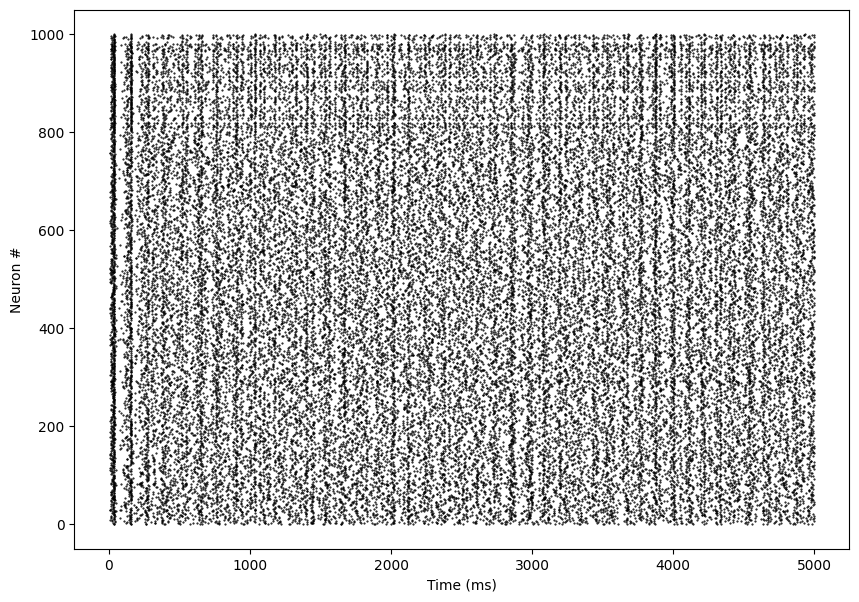

In [18]:
# Visualize spike raster plot
fig, ax = plt.subplots(1, figsize=(10, 7))

plt.plot(firings[0, :], firings[1, :], 'k.', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
# plt.xlim([1000,2000])   # Uncomment to zoom in on a specific time window
plt.show()


## **Population Activity Visualization**

In [ ]:
# Compute population spiking activity over time
popact = np.zeros(simulation_time)  # Fraction of neurons firing at each ms

# Count number of spikes per time point (normalize to proportion)
for ti in range(simulation_time):
    popact[ti] = np.sum(firings[0, :] == ti) / (Ne + Ni)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# --- Time domain plot ---
ax[0].plot(popact)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Proportion of neurons active')
ax[0].set_title('Population spiking (time domain)')
# ax[0].set_xlim([1000, 1500])  # Uncomment to zoom in
# ax[0].set_ylim([0, .1])       # Uncomment to set y-limits

# --- Frequency domain plot ---
# Remove DC offset before FFT for better frequency analysis
popact_demeaned = popact - np.mean(popact)
popactX = np.abs(np.fft.fft(popact_demeaned))
hz = np.linspace(0, 500, int(simulation_time / 2 + 1))  # Frequency axis up to Nyquist (500 Hz here)

ax[1].plot(hz, popactX[:len(hz)], 'k', linewidth=3)
ax[1].set_xlim([0, 80])  # Focus on relevant frequency range (0-80 Hz)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (a.u.)')
ax[1].set_title('Population spiking (frequency domain)')

plt.tight_layout()
plt.show()


## **Experiment Time**

In [20]:
def simCircuit(I):
    """
    Simulate a recurrent neural circuit of excitatory and inhibitory Izhikevich neurons.

    Parameters
    ----------
    I : array_like, shape (simulation_time,)
        External input (current) per time step (same for all neurons).

    Returns
    -------
    firings : ndarray, shape (2, num_spikes)
        Array of spike events: first row = time, second row = neuron index.
    """
    # Initialize spike recording array (rows: time, neuron_index)
    firings = np.array([[], []])

    # Initialize membrane potential (v) and recovery variable (u) for all neurons
    v = -65 * np.ones(Ne + Ni)
    u = b * v

    # Loop over simulation time
    for t in range(len(I)):

        # Build external stimulation vector for all neurons at time t:
        # - Each neuron gets some random "background" input
        # - All neurons receive the same additional current I[t]
        stim = np.hstack((4 * np.random.randn(Ne), 1 * np.random.randn(Ni))) + I[t]

        # Find indices of neurons that fired (v >= 30 mV)
        fired = np.where(v >= 30)[0]
        # Record spike events as [time, neuron_index] columns
        tmp = np.stack((np.tile(t, len(fired)), fired))
        firings = np.concatenate((firings, tmp), axis=1)

        # Reset state of neurons that fired
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        # Add recurrent input from all neurons that just fired
        # S[:, fired]: columns = presynaptic neurons that just fired
        # Sum input from all active presynaptic neurons for each postsynaptic neuron
        stim += np.sum(S[:, fired], axis=1)

        # Update membrane potential and recovery variable for all neurons
        v += 0.04 * v ** 2 + 5 * v + 140 - u + stim
        u += a * (b * v - u)

    return firings


In [21]:
def plotPopActivity(firings, I=None, sampling_rate=1000):
    """
    Visualize network spiking results.

    Parameters
    ----------
    firings : ndarray, shape (2, num_spikes)
        First row: time index; second row: neuron index.
    I : ndarray, optional
        Input current over time (should be 1D, length matches time).
    sampling_rate : int
        Simulation time step rate in Hz (default: 1000 for ms steps).
    """
    # Compute maximum simulation time
    npnts = int(np.max(firings[0, :]) + 1)  # +1 b/c starts at 0

    # Compute population spiking activity (proportion firing at each time)
    popact = np.zeros(npnts)
    for ti in range(npnts):
        popact[ti] = np.sum(firings[0, :] == ti) / (Ne + Ni)

    # Compute amplitude spectrum
    popactX = np.abs(np.fft.fft(popact - np.mean(popact)))
    hz = np.linspace(0, sampling_rate // 2, int(npnts / 2 + 1))

    # --- Plotting ---
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Raster plot
    ax[0].plot(firings[0, :], firings[1, :], 'k.', markersize=1)
    if I is not None:
        # Scaled input for visualization, adjust as needed
        ax[0].plot(np.arange(len(I)), I * 50 + 100, 'm', linewidth=2, label='Input (scaled)')
        ax[0].legend()
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Neuron index')
    ax[0].set_title('Spike raster')

    # Time-domain population activity
    ax[1].plot(popact)
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Proportion of neurons active')
    ax[1].set_title('Population activity (time domain)')

    # Frequency-domain amplitude spectrum
    ax[2].plot(hz, popactX[:len(hz)], 'k', linewidth=3)
    ax[2].set_xlim([0, 80])
    ax[2].set_xlabel('Frequency (Hz)')
    ax[2].set_ylabel('Amplitude (a.u.)')
    ax[2].set_title('Population activity (frequency domain)')

    plt.tight_layout()
    plt.show()


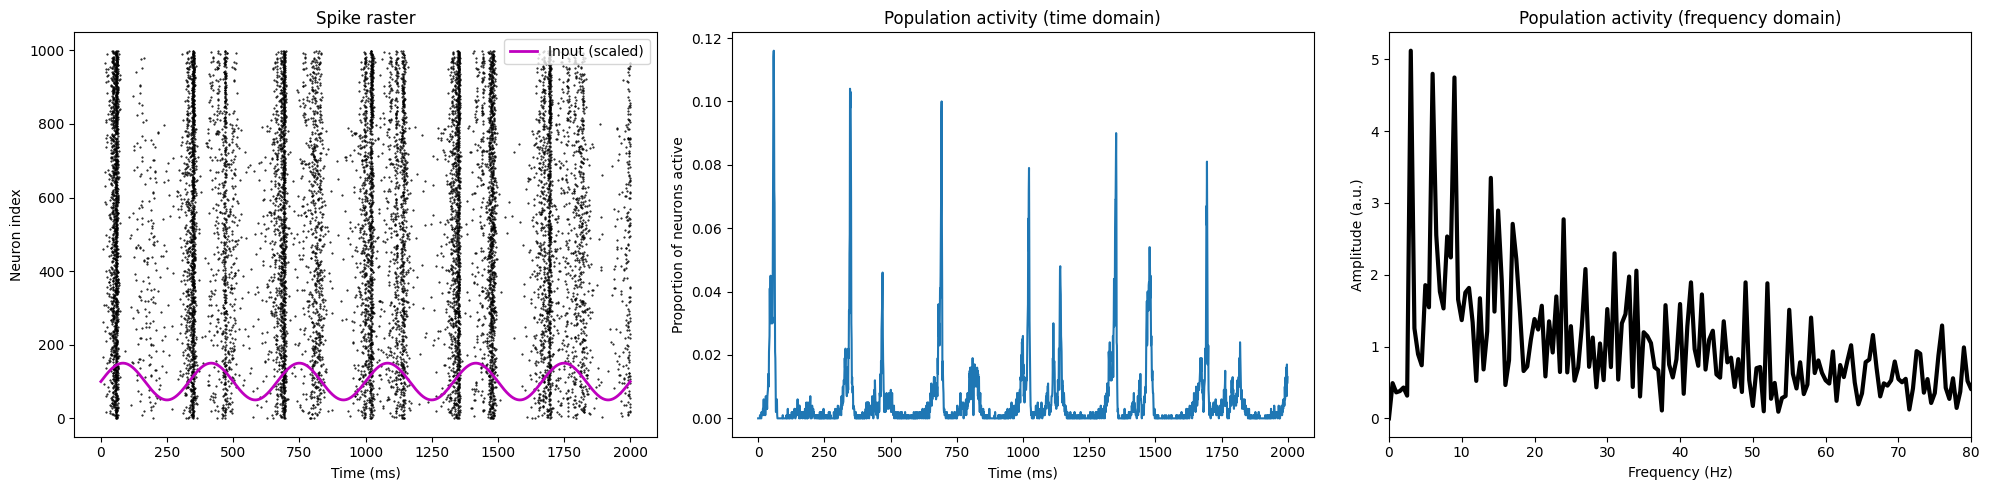

In [22]:
# ----------------
# Example experiments: define different input currents I
# ----------------

# Option 1: Step current with an inhibitory pulse
I = np.ones(1234)
I[400:601] = -2

# Option 2: Slowly varying input (parabolic ramp)
I = (np.linspace(-2, 2, 3001))**2

# Option 3: Oscillatory input (sinusoid, high frequency)
I = np.sin(np.linspace(0, 6*np.pi, 2000) * 2)  # 6 cycles over 2000 ms, doubled frequency

# ----------------
# Run simulation and visualize
# ----------------
networkspikes = simCircuit(I)
plotPopActivity(networkspikes, I=I)
